In [2]:
import gymnasium as gym
from matplotlib import pyplot as plt
import numpy as np
import pickle

## Epsilon-Greedy algorithm

### Epsilon-Greedy algorithm

The epsilon-greedy algorithm is a strategy used to balance between exploration and exploitation in reinforcement learning. Exploration involves taking actions to gather more information about the environment, while exploitation involves selecting actions that are believed to yield the highest immediate reward based on current knowledge. However, relying solely on exploitation may lead to suboptimal decisions. Epsilon-greedy addresses this dilemma by randomly selecting between exploration and exploitation, with the parameter epsilon determining the probability of exploration. This approach allows the agent to primarily exploit known information while occasionally exploring new options to improve its understanding of the environment.
<br><br>
In this code snippet, the epsilon-greedy algorithm is implemented to balance between exploration and exploitation in decision-making. Initially, a random number is generated, and if this number is less than the epsilon value (typically set to 1 by default), the agent takes a random action, facilitating exploration of the environment. Conversely, if the generated number exceeds epsilon, the agent selects an action based on the Q-values, prioritizing exploitation of known information to maximize immediate rewards.

```python
        # Exploration vs Exploitation trade-off
        if isTraining and rng.random() < epsilon:
            action = env.action_space.sample()  # Random action
        else:
            action = np.argmax(q[state,:])  # Greedy action based on Q-value
```
<br>

Following the epsilon-greedy strategy, epsilon is subsequently reduced using the epsilon_decay_rate parameter. This reduction in epsilon over time gradually shifts the agent's behavior towards exploitation, as exploration becomes less frequent with each iteration. By decreasing epsilon, the agent becomes increasingly reliant on its learned Q-values to make decisions.

```python
        # Epsilon decay
        epsilon = max(epsilon - epsilon_decay_rate, 0)

```

<strong>Source:</strong><br>
GfG. (2023, January 10). Epsilon-Greedy algorithm in reinforcement learning. GeeksforGeeks. https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/

### Parameters

<strong>render</strong><br>
The parameter "render" determines whether the game is rendered during training and is stored as a boolean value. When set to False, the game will not be rendered, resulting in a faster training process. However, this also means that the training progress is not visible during the training session.


<strong>isTraining</strong><br>
The parameter "isTraining" determines whether the game is actively training a model or if it is using a previously trained model to perform a task. When set to True, the game is in the training mode, actively training a model. Conversely, when set to False, the game utilizes the last trained model to perform the task without further training.


<strong>episodes</strong><br>
This parameter, referred to as "episodes," dictates the number of learning iterations the model will undergo. It essentially defines the total number of training iterations or epochs the model will execute during the learning process.


<strong>learning_rate_a</strong><br>
This is the learning rate, denoted by the symbol α in the Q-learning algorithm. It determines to what extent the newly acquired information overrides the existing information in the Q-table.


<strong>discount_factor_g</strong><br>
This is the discount factor, denoted by the symbol γ in the Q-learning algorithm. It represents the importance of future rewards relative to immediate rewards. It discounts the value of future rewards that are further in time.


<strong>epsilon</strong><br>
Epsilon (ε) is a parameter that controls the exploration vs. exploitation trade-off in reinforcement learning. A high epsilon value encourages more exploration, meaning the agent chooses random actions more frequently, while a low epsilon value encourages exploitation, meaning the agent relies more on its learned Q-values to select actions.


<strong>epsilon_decay_rate</strong><br>
This parameter determines the rate at which epsilon decreases over time. Typically, epsilon starts at a relatively high value and gradually decays towards zero as the agent learns more about the environment.

### Functions

In [3]:
# Model using the Epsilon Greedy algorithm
def frozenLakeEpsilonGreedy(
        is_slippery=True, 
        render=False, 
        isTraining=True, 
        episodes=10000, 
        learning_rate_a=0.8, 
        discount_factor_g=0.9, 
        epsilon=1, 
        epsilon_decay_rate=0.0001):
    
    # Environment setup
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=is_slippery, render_mode='human' if render else None)

    if isTraining:
        # Q-table initialization
        q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        f = open('frozen_lake8x8.pk1', 'rb')
        q = pickle.load(f)
        f.close()

    # Random number generator
    rng = np.random.default_rng()

    # Rewards per episode initialization
    rewards_per_episode = np.zeros(episodes)

    # Loop over episodes
    for i in range(episodes):
        # Reset environment
        state = env.reset()[0]
        terminated = False
        truncated = False

        # Episode loop
        while(not terminated and not truncated):
            # Exploration vs Exploitation trade-off
            if isTraining and rng.random() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                action = np.argmax(q[state,:])  # Greedy action based on Q-values

            # Take a step in the environment
            new_state, reward, terminated, truncated, _ = env.step(action)

            if isTraining:
                # Q-value update using Q-learning equation
                q[state, action] = q[state, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state, action]
                )

            # Transition to the new state
            state = new_state

        # Epsilon decay
        epsilon = max(epsilon - epsilon_decay_rate, 0)

        # Learning rate decay
        if epsilon == 0:
            learning_rate_a = 0.0001

        # Store rewards for this episode
        if reward == 1:
            rewards_per_episode[i] = 1

    # Close the environment
    env.close()

    # Cumulative sum of rewards over 1000 episodes
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    return sum_rewards, q

# Save function to save the model
def save(q_tabel, sum_rewards):
    # Plotting
    plt.plot(sum_rewards)
    plt.savefig('frozen_lake8x8.png')  # Save plot to a file

    # Save Q-table to a file
    f = open("frozen_lake8x8.pk1","wb")
    pickle.dump(q_tabel, f)
    f.close()

# Plot function to plot the rewards graph
def plot(sum_rewards, label:str):
    plt.plot(
        sum_rewards, 
        label=label)


### Is_slippery parameter

The is_slippery parameter, when enabled, introduces stochasticity or randomness into the agent's movement within the environment. This randomness can cause the agent to deviate from its intended path and potentially hinder its ability to reach the goal, even if it possesses knowledge about the environment. Essentially, it adds an element of uncertainty to the agent's actions, which can impact its decision-making process and overall performance in the environment.

In [51]:
sum_rewardsON, _ = frozenLakeEpsilonGreedy(
    is_slippery=True,
    render=False,
    isTraining=True,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    epsilon=1,
    epsilon_decay_rate=0.0001
)

sum_rewardsOFF, _ = frozenLakeEpsilonGreedy(
    is_slippery=False,
    render=False,
    isTraining=True,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    epsilon=1,
    epsilon_decay_rate=0.0001
)

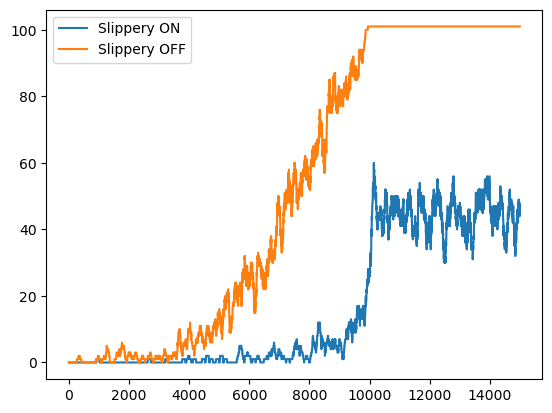

In [52]:
plot(
    sum_rewards=sum_rewardsON,
    label='Slippery ON')
plot(
    sum_rewards=sum_rewardsOFF,
    label='Slippery OFF')
plt.legend()
plt.show()

The graphs clearly demonstrate that with the is_slippery parameter disabled, the agent consistently navigates the correct path in the environment. This is expected because without stochasticity in the agent's movements, it can reliably follow the optimal path to reach the goal. Conversely, when is_slippery is enabled, the agent's path becomes less predictable due to random movements, leading to occasional deviations from the optimal route. This highlights the impact of stochasticity on the agent's ability to navigate the environment effectively.

### Epsilon vs Reward

I have rewritten the method to focus solely on essential parameters and removed unnecessary ones such as "render" and "is_training". Default values have been set for parameters to simplify function calls. Additionally, I adjusted the results by dividing the sum results by 100, enabling values to range between 0 and 1 instead of 0 and 100. This modification facilitates plotting of epsilons and sum of rewards on the same graph.

In [5]:
# Model using the Epsilon Greedy algorithm
def frozenLakeEpsilonGreedyEpsilonVsReward(
        episodes=15000, 
        learning_rate_a=0.8, 
        discount_factor_g=0.9, 
        epsilon=1, 
        epsilon_decay_rate=0.0001):
    # Epsilons storage
    epsilons = []

    # Environment setup
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode=None)

    q = np.zeros((env.observation_space.n, env.action_space.n))

    # Random number generator
    rng = np.random.default_rng()

    # Rewards per episode initialization
    rewards_per_episode = np.zeros(episodes)

    # Loop over episodes
    for i in range(episodes):
        # Reset environment
        state = env.reset()[0]
        terminated = False
        truncated = False

        # Episode loop
        while(not terminated and not truncated):
            # Exploration vs Exploitation trade-off
            if rng.random() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                action = np.argmax(q[state,:])  # Greedy action based on Q-values

            # Take a step in the environment
            new_state, reward, terminated, truncated, _ = env.step(action)

            # Q-value update using Q-learning equation
            q[state, action] = q[state, action] + learning_rate_a * (
                reward + discount_factor_g * np.max(q[new_state,:]) - q[state, action]
            )

            # Transition to the new state
            state = new_state

        # Epsilon decay
        epsilon = max(epsilon - epsilon_decay_rate, 0)
        epsilons.append(epsilon)

        # Learning rate decay
        if epsilon == 0:
            learning_rate_a = 0.0001

        # Store rewards for this episode
        if reward == 1:
            rewards_per_episode[i] = 1

    # Close the environment
    env.close()

    # Cumulative sum of rewards over 1000 episodes
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])/100

    return sum_rewards, epsilons

By plotting both the sum of rewards and the epsilons, we observe a significant increase in the sum of rewards once the epsilon reaches 0. This sharp increase occurs because the algorithm consistently selects the best q-value instead of opting for a random choice. With an epsilon value of 0, exploration ceases, compelling the agent to always choose the optimal path.
<br><br>
<strong>Sources:</strong><br>
Does RL methods converge with epsilon = 0? (n.d.). Stack Overflow. https://stackoverflow.com/questions/58343511/does-rl-methods-converge-with-epsilon-0

In [29]:
sum_rewards, epsilons = frozenLakeEpsilonGreedyEpsilonVsReward()
sum_rewardsHigh, epsilonsHigh = frozenLakeEpsilonGreedyEpsilonVsReward(epsilon_decay_rate=0.0005)

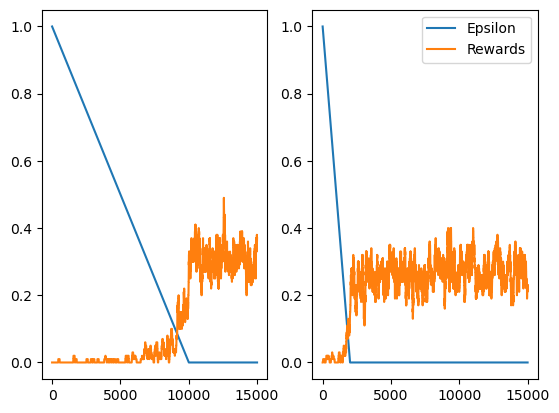

In [30]:
fig, axs = plt.subplots(1,2)

axs[0].plot(epsilons,
            label='Epsilon')
axs[0].plot(sum_rewards,
            label='Rewards')
axs[1].plot(epsilonsHigh,
            label='Epsilon')
axs[1].plot(sum_rewardsHigh,
            label='Rewards')

plt.legend()

### Epsilon experiment

<strong>Question:</strong><br>
<em>What is the best Epsilon value to balanse the exploration and exploitation?</em>

<strong>Experiment:</strong><br>
The experimentation involves varying the epsilon value, which dictates the balance between exploration and exploitation in the reinforcement learning model. By adjusting the start value of epsilon, different exploration-exploitation trade-offs can be evaluated. The code snippet provided iterates over multiple epsilon values to train the RL model, and the resulting rewards are plotted for analysis. It's important to note that a reward outcome of 0 signifies that the agent never found the reward, potentially indicating insufficient exploration. To mitigate the impact of such occurrences, the experiment will be conducted 10 times to ensure robustness in the results and to account for variations in the agent's learning process across different epsilon values.

<strong>Results:</strong><br>
<table>
  <tr>
    <th>Iteration</th>
    <th>eps: 2</th>
    <th>eps: 1</th>
    <th>eps: 0.9</th>
    <th>eps: 0.8</th>
    <th>eps: 0.7</th>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>40</td>
    <td>20</td>
    <td>0</td>
    <td>50</td>
  </tr>
  <tr>
    <td>2</td>
    <td>1</td>
    <td>0</td>
    <td>30</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>3</td>
    <td>1</td>
    <td>40</td>
    <td>40</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>4</td>
    <td>1</td>
    <td>50</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>5</td>
    <td>1</td>
    <td>31</td>
    <td>1</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>6</td>
    <td>1</td>
    <td>15</td>
    <td>0</td>
    <td>50</td>
    <td>0</td>
  </tr>
  <tr>
    <td>7</td>
    <td>2</td>
    <td>40</td>
    <td>20</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>8</td>
    <td>3</td>
    <td>45</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>9</td>
    <td>1.5</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>10</td>
    <td>1</td>
    <td>60</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
</table>
<br>

<strong>Conclusion:</strong><br>
<table>
    <tr>
        <th>
        <th>eps: 2</th>
        <th>eps: 1</th>
        <th>eps: 0.9</th>
        <th>eps: 0.8</th>
        <th>eps: 0.7</th>
    </tr>
    <tr>
        <td>Average</td>
        <td>1,35</td>
        <td>32.1</td>
        <td>11.1</td>
        <td>5.0</td>
        <td>5.0</td>
    </tr>
    <tr>
        <td>Highest value</td>
        <td>3.0</td>
        <td>60.0</td>
        <td>40.0</td>
        <td>50.0</td>
        <td>50.0</td>
    <tr>
        <td>Amount of 0</td>
        <td>0</td>
        <td>2</td>
        <td>5</td>
        <td>9</td>
        <td>9</td>
    </tr>
</table>

After analyzing the values presented in the table above, it is evident that an epsilon value of 1 yields the most favorable results. This conclusion is drawn based on several factors: the highest average reward, the highest reward value achieved, and comparatively fewer instances of zero rewards. Given the context of the problem scenario, specifically in the Frozen Lake environment utilizing the epsilon-greedy algorithm, an epsilon value of 1 emerges as the optimal choice.

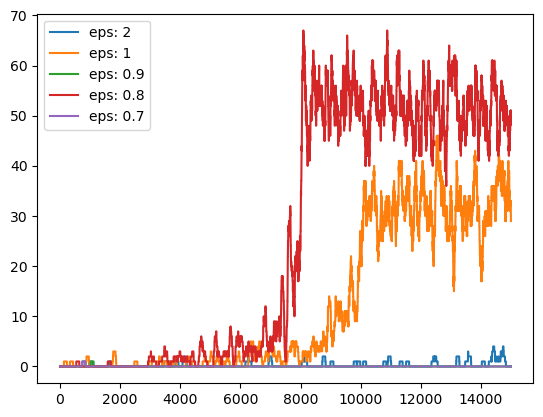

In [3]:
epsilons = [2, 1, 0.9, 0.8, 0.7]
for epsilon in epsilons:
    sum_rewards, _ = frozenLakeEpsilonGreedy(
        render=False,
        isTraining=True,
        episodes=15000,
        learning_rate_a=0.8,
        discount_factor_g=0.9,
        epsilon=epsilon,
        epsilon_decay_rate=0.0001
    )

    plot(sum_rewards=sum_rewards,
         label=f'eps: {epsilon}')
plt.legend()
plt.show()

### Epsilon decay rate experiment

<strong>Question:</strong><br>
<em>What is the best Epsilon decay rate to balanse the exploration and exploitation?</em>

<strong>Experiment:</strong><br>
The experimentation entails adjusting the epsilon decay rate to ascertain the optimal balance between exploration and exploitation for the agent. The epsilon decay rate is the parameter responsible for reducing the epsilon value after each episode until it reaches 0, as depicted in the code snippet provided below.

```python
        # Epsilon decay
        epsilon = max(epsilon - epsilon_decay_rate, 0)
```
Given that the epsilon greedy algorithm relies on the epsilon value to determine whether to choose a random action or an action based on learned values, the significance of this parameter cannot be overstated. A lower epsilon value increases the likelihood of the agent selecting a learned action over a random one. It is intriguing to investigate under which conditions the agent performs better: with a low epsilon or a higher one.

<strong>Results:</strong><br>
The results of this experiment are characterized by two crucial metrics: the increase in the sum of rewards over time, and the average sum of rewards at the end of the experiment. The table labeled "up" contains data indicating episodes where there was a significant increase in the sum of rewards. Conversely, the "ended" table stores the average sum of rewards at the conclusion of the experiment, specifically after notable upward changes in the sum of rewards occurred.<br>

<strong>Ended Values</strong>
<table>
  <tr>
    <th>Iteration</th>
    <th>Decay Rate 0.0001</th>
    <th>Decay Rate 0.0002</th>
    <th>Decay Rate 0.0003</th>
    <th>Decay Rate 0.0004</th>
    <th>Decay Rate 0.0005</th>
  </tr>
  <tr>
    <td>1</td>
    <td>40</td>
    <td>40</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>40</td>
    <td>40</td>
    <td>0</td>
    <td>25</td>
    <td>0</td>
  </tr>
  <tr>
    <td>3</td>
    <td>45</td>
    <td>25</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>4</td>
    <td>20</td>
    <td>0</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>5</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>35</td>
  </tr>
  <tr>
    <td>6</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>7</td>
    <td>25</td>
    <td>30</td>
    <td>0</td>
    <td>25</td>
    <td>0</td>
  </tr>
  <tr>
    <td>8</td>
    <td>40</td>
    <td>10</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>9</td>
    <td>0</td>
    <td>0</td>
    <td>35</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>10</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>20</td>
  </tr>
</table>

<strong>Up Values</strong>
<table>
  <tr>
    <th>Iteration</th>
    <th>Decay Rate 0.0001</th>
    <th>Decay Rate 0.0002</th>
    <th>Decay Rate 0.0003</th>
    <th>Decay Rate 0.0004</th>
    <th>Decay Rate 0.0005</th>
  </tr>
  <tr>
    <td>1</td>
    <td>10000</td>
    <td>5000</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>2</td>
    <td>10000</td>
    <td>5000</td>
    <td>no</td>
    <td>2500</td>
    <td>no</td>
  </tr>
  <tr>
    <td>3</td>
    <td>10000</td>
    <td>4900</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>4</td>
    <td>10000</td>
    <td>no</td>
    <td>3000</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>5</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>2000</td>
  </tr>
  <tr>
    <td>6</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>7</td>
    <td>10000</td>
    <td>5000</td>
    <td>no</td>
    <td>2000</td>
    <td>no</td>
  </tr>
  <tr>
    <td>8</td>
    <td>10000</td>
    <td>5000</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>9</td>
    <td>no</td>
    <td>no</td>
    <td>3000</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>10</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>4500</td>
  </tr>
</table>
<br>

<strong>Conclusion</strong>
<table>
  <tr>
    <th></th>
    <th>Decay Rate 0.0001</th>
    <th>Decay Rate 0.0002</th>
    <th>Decay Rate 0.0003</th>
    <th>Decay Rate 0.0004</th>
    <th>Decay Rate 0.0005</th>
  </tr>
  <tr>
    <td>Average ended value</td>
    <td>21,0</td>
    <td>14,5</td>
    <td>6,7</td>
    <td>5,0</td>
    <td>5,5</td>
  </tr>
  <tr>
    <td>Higest ended value</td>
    <td>45</td>
    <td>40</td>
    <td>35</td>
    <td>25</td>
    <td>35</td>
  </tr>
  <tr>
    <td>Average up value</td>
    <td>6000,0</td>
    <td>2490,0</td>
    <td>600,0</td>
    <td>450,0</td>
    <td>650,0</td>
  </tr>
  <tr>
    <td>Higest up value</td>
    <td>10000</td>
    <td>5000</td>
    <td>3000</td>
    <td>2500</td>
    <td>4500</td>
  </tr>
  <tr>
    <td>Amount of 0</td>
    <td>4</td>
    <td>5</td>
    <td>8</td>
    <td>8</td>
    <td>8</td>
  </tr>
</table>

Based on the analysis presented in the conclusion table, it is evident that a decay rate of 0.0001 yields the most favorable results in terms of reward outcomes. However, it is important to note that this decay rate requires a longer training duration, as indicated by the average "up" value. Conversely, a decay rate of 0.0002 exhibits lower reward outcomes but significantly shorter training times. The optimal choice between these options depends on the prioritization of speed versus reward attainment. In this context, where reward achievement holds greater significance, a decay rate of 0.0001 emerges as the preferred option.

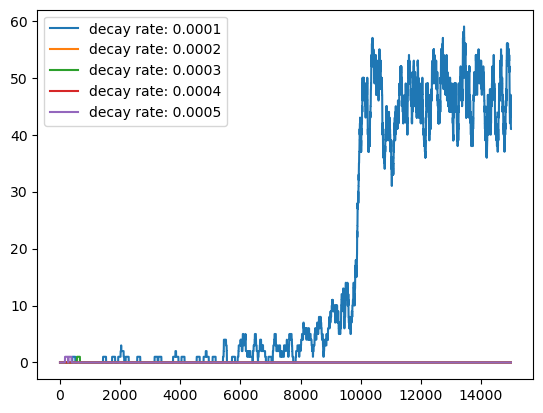

In [4]:
epsilons_decay_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
for epsilon_decay_rate in epsilons_decay_rates:
    sum_rewards, _ = frozenLakeEpsilonGreedy(
        render=False,
        isTraining=True,
        episodes=15000,
        learning_rate_a=0.8,
        discount_factor_g=0.9,
        epsilon=1,
        epsilon_decay_rate=epsilon_decay_rate
    )

    plot(sum_rewards=sum_rewards,
         label=f'decay rate: {epsilon_decay_rate}')
plt.legend()
plt.show()

### Best result

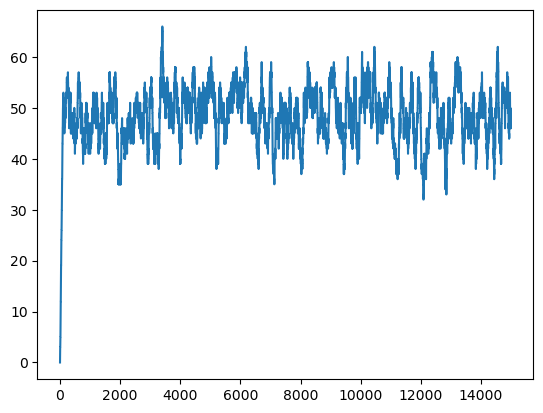

In [6]:
sum_rewards, q_tabel = frozenLakeEpsilonGreedy(
    render=False,
    isTraining=False,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    epsilon=1,
    epsilon_decay_rate=0.0001
)

save(sum_rewards=sum_rewards,
     q_tabel=q_tabel)

## Boltzmann Policy

### Boltzmann algorithm

The Boltzmann policy offers an alternative approach to the epsilon-greedy algorithm. Instead of randomly selecting an action, the agent makes decisions based on the probabilities derived from the Q-values of each action. This method employs softmax selection rules to rank and weight all possible actions. Below is a code snippet illustrating the implementation:<br>

```python
        # Apply softmax with temperature
        value = (action_values - np.nanmax(action_values)) / temperature  
        # Computing element wise exponential value
        exp_values = np.exp(values)
        # Compute softmax
        probs = exp_values/np.sum(exp_values)
```
In this code snippet, action_values represents the Q-values associated with each action for the current state. Each Q-value corresponds to a specific action, indicating the expected future reward if that action is taken in the current state. The action_values variable is structured as an array or a list, with each element corresponding to a different action. Below is a code snipped showing the implementation:<br>

```python
        # Get Q-values for current state
        action_values = q[state, :]  
```
In this code snippet, the probs (probabilities) variable is utilized to determine the likelihood of selecting each action by the agent. Unlike deterministic methods where the agent always chooses the same action or random methods where actions are selected uniformly at random, the probs allow for a more nuanced selection process. For example, in environments with stochasticity or slippery dynamics, such as in the case when the slippery parameter is turned on, the agent may need to consider alternative routes to reach the reward. By using probabilities, the agent can explore different actions based on their likelihood of leading to favorable outcomes, thus improving its adaptability and performance in such environments.

### Functions

In [6]:
# Defining the softmax function
def softmax(values):
    # Computing element wise exponential value
    exp_values = np.exp(values)

    # Compute softmax
    probs = exp_values/np.sum(exp_values)
    
    # Returing the softmax output without Nan.
    if np.isnan(probs).any():
        probs = np.nan_to_num(probs)
    return probs

In [4]:
def frozenLakeBoltzmannPolicy(
        is_slippery=True, 
        render=False, 
        isTraining=True, 
        episodes=10000, 
        learning_rate_a=0.8, 
        discount_factor_g=0.9, 
        temperature=1, 
        temperature_decay_rate=0.0001):
    
    # Create FrozenLake environment
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=is_slippery, render_mode='human' if render else None)

    # Initialize Q-table
    if isTraining:
        q = np.zeros((env.observation_space.n, env.action_space.n))  # Q-table for state-action values
    else:
        f = open('frozen_lake8x8.pk1', 'rb')
        q = pickle.load(f)  # Load pre-trained Q-table
        f.close()

    rng = np.random.default_rng()  # Random number generator

    rewards_per_episode = np.zeros(episodes)  # Track rewards per episode

    # Loop over episodes
    for i in range(episodes):
        state = env.reset()[0]  # Reset environment and get initial state
        terminated = False  # Flag for episode termination
        truncated = False  # Flag for episode truncation

        # Loop until episode terminates or truncates
        while not terminated and not truncated:
            if isTraining:
                action_values = q[state, :]  # Get Q-values for current state
                value = (action_values - np.nanmax(action_values)) / temperature  # Apply softmax with temperature
                probs = softmax(value)  # Get action probabilities using softmax
                action = np.random.choice(len(probs), p=probs)  # Choose action based on probabilities
            else:
                action = np.argmax(q[state,:])

            # Take action and observe new state and reward
            new_state, reward, terminated, truncated, _ = env.step(action)

            # Update Q-values if in training mode
            if isTraining:
                q[state, action] = q[state, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state, :]) - q[state, action]
                )

            state = new_state  # Update current state

        # Decay temperature
        temperature = max(temperature - temperature_decay_rate, 0.0001)

        # Update learning rate if temperature reaches 0
        if temperature == 0:
            learning_rate_a = 0.0001

        # Track rewards obtained in the episode
        if reward == 1:
            rewards_per_episode[i] = 1

    env.close()  # Close the environment

    # Compute cumulative rewards over 100 episodes
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t - 100):(t + 1)])

    return sum_rewards, q

# Save function to save the model
def save(q_tabel, sum_rewards):
    # Plotting
    plt.plot(sum_rewards)
    plt.savefig('frozen_lake8x8.png')  # Save plot to a file

    # Save Q-table to a file
    f = open("frozen_lake8x8.pk1","wb")
    pickle.dump(q_tabel, f)
    f.close()

# Plot function to plot the rewards graph
def plot(sum_rewards, label):
    plt.plot(
        sum_rewards,
        label=label)


### Is_slippery parameter

The experimentation involves training two separate models, each with a different setting for the is_slippery parameter. By training one model with is_slippery enabled and another with it disabled, we aim to observe how this parameter affects the outcome of the algorithm. This comparative analysis will provide insights into the impact of stochasticity on the agent's performance and navigation in the environment.

In [9]:
sum_rewardsON, _  = frozenLakeBoltzmannPolicy(
    is_slippery=True,
    render=False,
    isTraining=True,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0001
)
sum_rewardsOFF, _ = frozenLakeBoltzmannPolicy(
    is_slippery=False,
    render=False,
    isTraining=True,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0001
)

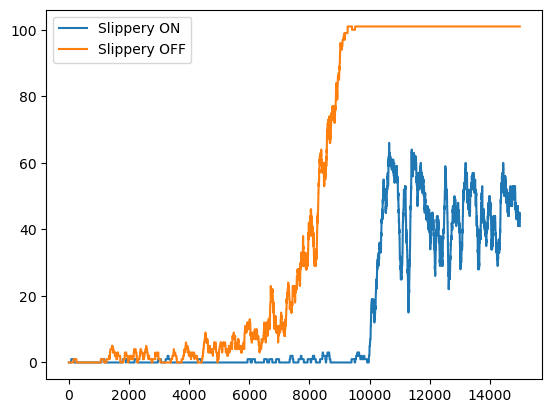

In [10]:
plot(sum_rewards=sum_rewardsON,
     label='Slippery ON')
plot(sum_rewards=sum_rewardsOFF,
     label='Slippery OFF')
plt.legend()
plt.show()

Based on the visual analysis of the graphs presented, it is evident that when the is_slippery parameter is disabled, the agent consistently follows a perfect path to reach its goal. In contrast, when is_slippery is enabled, the agent's path becomes less predictable, indicating that stochasticity introduced by this parameter affects the agent's navigation in the environment. Therefore, it can be concluded that the presence of stochasticity, as controlled by the is_slippery parameter, influences the agent's ability to consistently navigate to its goal.

### Comparison

As I discussed in the explenation on the boltzmann policy, this algorithm should preform better when slippery is turned on. I want to test this by comparing both the results of the greedy algortihm and the results of the boltzmann algorithm in the same plot.

In [27]:
sum_rewardsBoltz, _ = frozenLakeBoltzmannPolicy(
    is_slippery=True,
    render=False,
    isTraining=True,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0001
)

sum_rewardsGreedy, _ = frozenLakeEpsilonGreedy(
    is_slippery=True,
    render=False,
    isTraining=True,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    epsilon=1,
    epsilon_decay_rate=0.0001
)

sum_rewardsBoltzFalse, _ = frozenLakeBoltzmannPolicy(
    is_slippery=True,
    render=False,
    isTraining=False,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0001
)

sum_rewardsGreedyFalse, _ = frozenLakeEpsilonGreedy(
    is_slippery=True,
    render=False,
    isTraining=False,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    epsilon=1,
    epsilon_decay_rate=0.0001
)

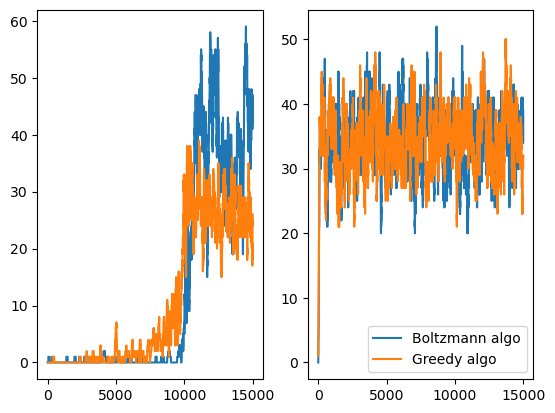

In [28]:
fig, axs = plt.subplots(1,2)
axs[0].plot(sum_rewardsBoltz,
            label='Boltzmann algo')

axs[0].plot(sum_rewardsGreedy,
            label='Greedy algo')

axs[1].plot(sum_rewardsBoltzFalse,
            label='Boltzmann algo')

axs[1].plot(sum_rewardsGreedyFalse,
            label='Greedy algo')

plt.legend()
plt.show()

As observed from the plotted results, during training, the Boltzmann algorithm exhibits slightly superior performance when the is_slippery parameter is enabled. This observation is consistent with the anticipated behavior discussed earlier, suggesting that the Boltzmann algorithm might excel in navigating environments characterized by stochastic elements like slippery surfaces. However, when utilizing the trained models, it becomes apparent that both models perform equally well. This parity arises from both models having identified the optimal path and consistently attempting to follow it.

### Temperature behaviour

Upon examining the code and the results obtained thus far, it appears that the temperature parameter exhibits similar behavior to the epsilon value in the epsilon-greedy algorithm. To test this hypothesis, I propose plotting the temperature against the sum of rewards. If the temperature mirrors the behavior of epsilon, we would expect to see a sharp increase in rewards when the temperature reaches its minimum value of 0.0001. This experiment will provide insights into the relationship between temperature and reward accumulation in the Boltzmann algorithm.

In [7]:
def frozenLakeBoltzmannPolicyTemps(
        episodes=10000, 
        learning_rate_a=0.8, 
        discount_factor_g=0.9, 
        temperature=1, 
        temperature_decay_rate=0.0001):
    # Temerature storage
    temperatures = []
    
    # Create FrozenLake environment
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode=None)

    # Initialize Q-table
    q = np.zeros((env.observation_space.n, env.action_space.n))  # Q-table for state-action values

    rng = np.random.default_rng()  # Random number generator

    rewards_per_episode = np.zeros(episodes)  # Track rewards per episode

    # Loop over episodes
    for i in range(episodes):
        state = env.reset()[0]  # Reset environment and get initial state
        terminated = False  # Flag for episode termination
        truncated = False  # Flag for episode truncation

        # Loop until episode terminates or truncates
        while not terminated and not truncated:
            action_values = q[state, :]  # Get Q-values for current state
            value = (action_values - np.nanmax(action_values)) / temperature  # Apply softmax with temperature
            probs = softmax(value)  # Get action probabilities using softmax
            action = np.random.choice(len(probs), p=probs)  # Choose action based on probabilities

            # Take action and observe new state and reward
            new_state, reward, terminated, truncated, _ = env.step(action)

            # Update Q-values if in training mode
            q[state, action] = q[state, action] + learning_rate_a * (
                reward + discount_factor_g * np.max(q[new_state, :]) - q[state, action]
            )

            state = new_state  # Update current state

        # Decay temperature
        temperature = max(temperature - temperature_decay_rate, 0.0001)
        temperatures.append(temperature)

        # Update learning rate if temperature reaches 0
        if temperature == 0:
            learning_rate_a = 0.0001

        # Track rewards obtained in the episode
        if reward == 1:
            rewards_per_episode[i] = 1

    env.close()  # Close the environment

    # Compute cumulative rewards over 100 episodes
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t - 100):(t + 1)])/100

    return sum_rewards, temperatures

In [46]:
sum_rewardsBoltz, temps = frozenLakeBoltzmannPolicyTemps(
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0001
)

sum_rewardsBoltzLow, tempsLow = frozenLakeBoltzmannPolicyTemps(
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0005
)

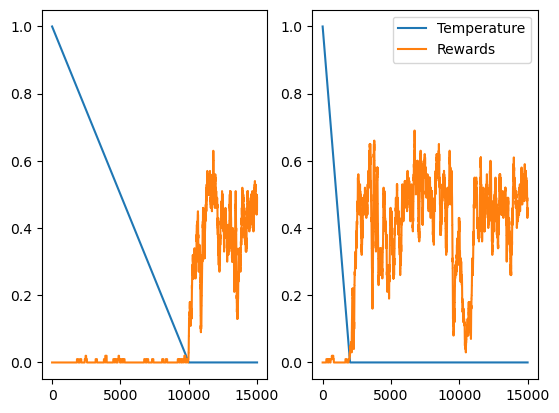

In [47]:
fig, axs = plt.subplots(1,2)
axs[0].plot(temps,
            label='Temperature')
axs[0].plot(sum_rewardsBoltz,
            label='Rewards')
axs[1].plot(tempsLow,
            label='Temperature')
axs[1].plot(sum_rewardsBoltzLow,
            label='Rewards')
plt.legend()
plt.show()

Based on the analysis of the plotted results, it is evident that the behavior of the temperature parameter closely resembles that of the epsilon value in the epsilon-greedy algorithm. However, a notable distinction is observed: the temperature never reaches 0. This discrepancy arises from the mathematical requirement to divide the action values by the temperature when calculating the value for the softmax function. As division by 0 is undefined, the minimum temperature is set to 0.0001 to avoid this issue. Despite this difference, the overall trend and impact on reward accumulation align closely with the behavior observed in the epsilon-greedy algorithm.<br>
```python
        value = (action_values - np.nanmax(action_values)) / temperature  # Apply softmax with temperature
```
<em><strong>Code snipped:</strong> Divide by temperature</em>

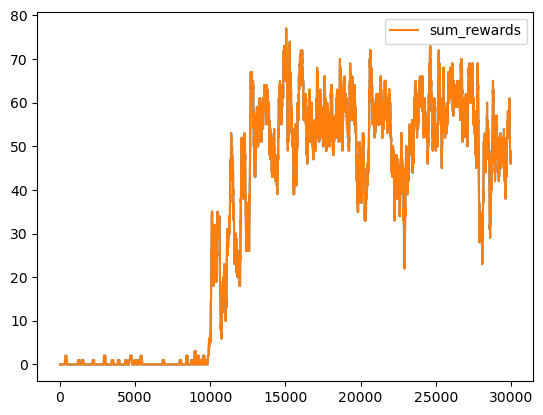

In [29]:
sum_rewards, q = frozenLakeBoltzmannPolicy(
    render=False,
    isTraining=True,
    episodes=30000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0001
)

save(q_tabel=q,
     sum_rewards=sum_rewards)

plot(sum_rewards=sum_rewards,
     label='sum_rewards')
plt.legend()
plt.show()

### Learning rate a parameter

The learning rate determines how much of the newly acquired information overrides the existing information in the q-table.

iteration 1:
- lr0.1: 61
- lr0.2: 45
- lr0.3: 55
- lr0.4: 59
- lr0.5: 40
- lr0.6: 55
- lr0.7: 30
- lr0.8: 45
- lr0.9: 31
- lr1.0: 2

iteration 2:
- lr0.1: 45
- lr0.2: 49
- lr0.3: 56
- lr0.4: 52
- lr0.5: 50
- lr0.6: 39
- lr0.7: 41
- lr0.8: 45
- lr0.9: 19
- lr1.0: 4

iteration 3:
- lr0.1: 52
- lr0.2: 40
- lr0.3: 57
- lr0.4: 54
- lr0.5: 59
- lr0.6: 46
- lr0.7: 48
- lr0.8: 33
- lr0.9: 28
- lr1.0: 3

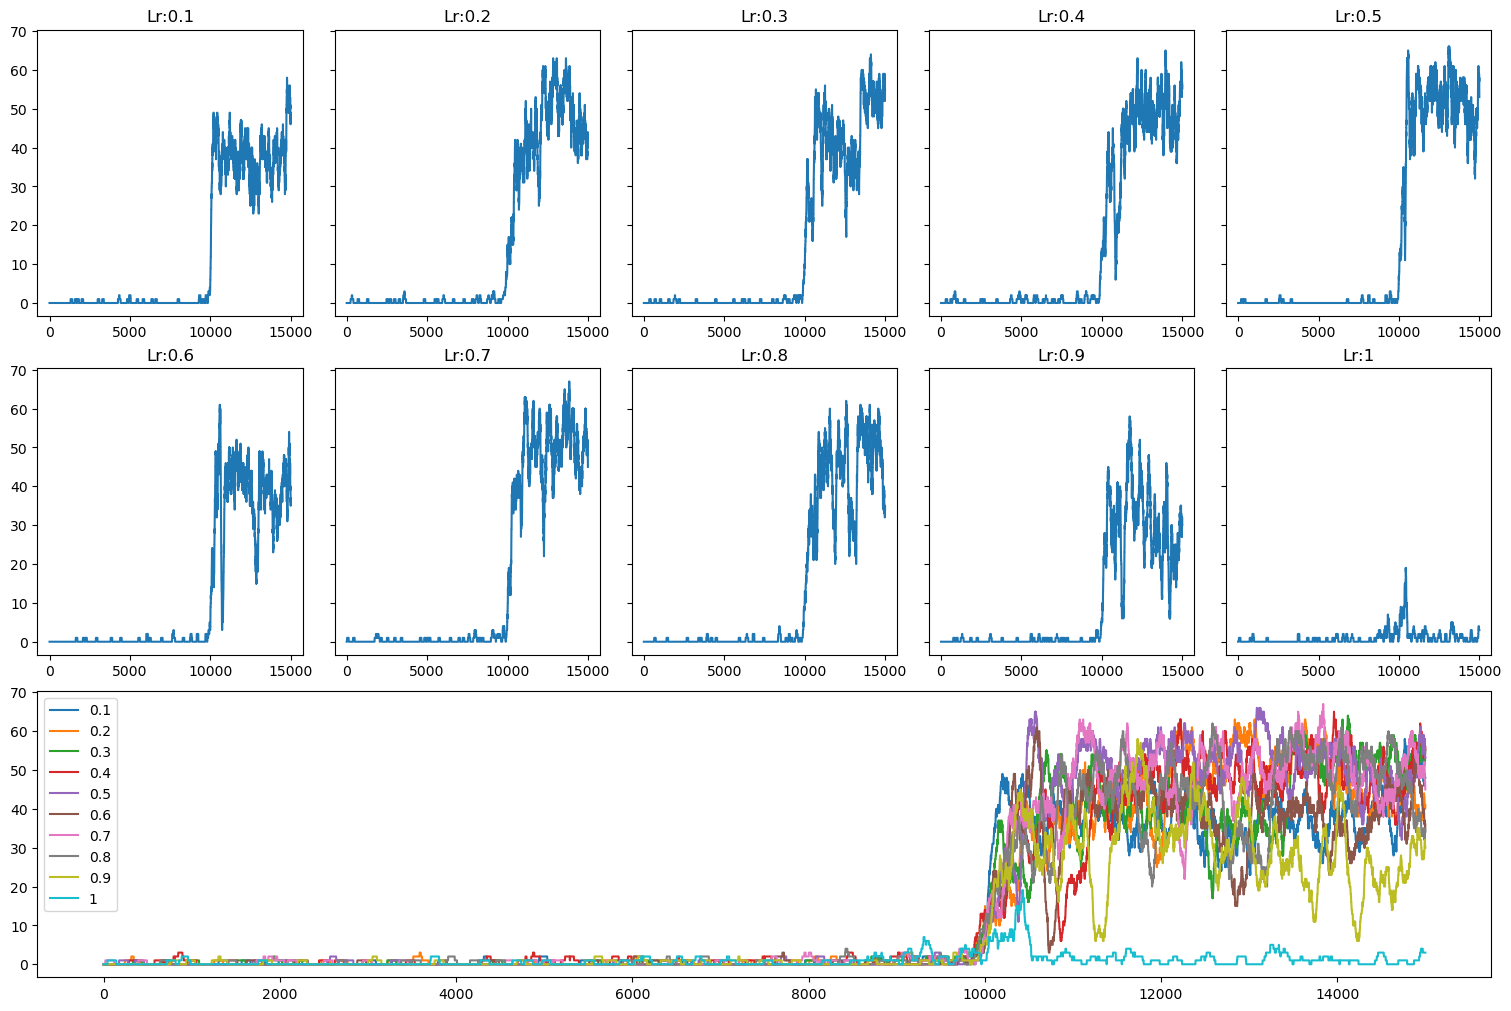

In [42]:
fig, axs = plt.subplot_mosaic([['0.1', '0.2', '0.3', '0.4', '0.5'], 
                               ['0.6', '0.7', '0.8', '0.9', '1'],
                               ['All', 'All', 'All', 'All', 'All']],
                               layout="constrained",
                               sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)

learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for learning_rate in learning_rates:
    sum_rewards, _ = frozenLakeBoltzmannPolicy(
        episodes=15000,
        learning_rate_a=learning_rate,
        discount_factor_g=0.9,
        temperature=1.0,
        temperature_decay_rate=0.0001
    )

    axs[f'{learning_rate}'].plot(sum_rewards,
                                 label=f'{learning_rate}')
    axs[f'{learning_rate}'].set_title(f'Lr:{learning_rate}')
    axs['All'].plot(sum_rewards,
                    label=f'{learning_rate}')
plt.legend()
plt.show()

## Rewards shoot up

Upon examining both the epsilon and temperature parameters, it becomes apparent that the rewards experience a sharp increase when these values drop below a certain threshold. This sudden spike in rewards may seem counterintuitive, as one might expect a more gradual increase as the epsilon or temperature decreases linearly. To gain further insights into this phenomenon, I propose to identify the specific threshold value at which the rewards sharply increase and investigate its implications on the overall behavior of the algorithm. This analysis aims to shed light on the underlying dynamics of reward accumulation in relation to the epsilon and temperature parameters.

In [8]:
sum_rewardsBoltz, tempsBoltz = frozenLakeBoltzmannPolicyTemps(
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0001
)

sum_rewardsGreedy, tempsGreedy = frozenLakeEpsilonGreedyEpsilonVsReward(
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    epsilon=1,
    epsilon_decay_rate=0.0001
)

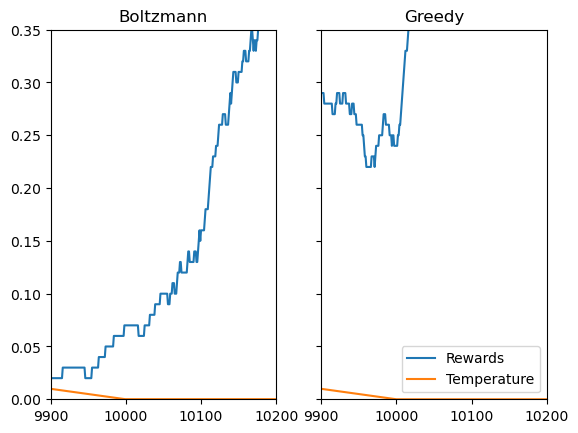

In [13]:
fig, axs = plt.subplots(1,2, sharey='all', sharex='all')

axs[0].plot(sum_rewardsBoltz,
            label='Rewards')
axs[0].plot(tempsBoltz,
            label='Temperature')
axs[0].set_title('Boltzmann')

axs[1].plot(sum_rewardsGreedy,
            label='Rewards')
axs[1].plot(tempsGreedy,
            label='Temperature')
axs[1].set_title('Greedy')

plt.legend()
plt.ylim([0, 0.35])
plt.xlim([9900, 10200])
plt.show()